# In this dataset

1. does it match the statistics of a high dimensional grid representation
2. Is the taurus real
3. test whether you can do the grid realignment like carpenter also in the big maze
4. show that correlation structure is preserved only in as far as cells are spatial

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 
from scipy.ndimage import gaussian_filter1d
import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)

sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

from mecll.rsync import Rsync_aligner
from mecll.proc_beh import get_all_transition, get_transitions_state, build_poke_df
from mecll.proc_neural import get_all_resps, get_mean_resps

In [3]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

# Actual code

In [4]:
#Load behavioural data
root_path = '/Users/yves/Downloads/example_files2_wOF/'

all_fs = os.listdir(root_path)

task_path = os.path.join(root_path,[i for i in all_fs if '.txt' in i][0])
lines = open(task_path,'r').readlines()


#load neural data timestamps

sync_path_spk = os.path.join(root_path,[i for i in all_fs if i=='timestamps.npy'][0])#'/Users/yves/Downloads/example_files/timestamps.npy'
sync_messages_spk = np.load(sync_path_spk)[::2][:-1].astype('float')


#load spiking data
#ROOT = '/Users/yves/Downloads/example_files/'
spkT = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_times.npy'][0])).flatten()
spkC = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_clusters.npy'][0])).flatten()
cluster_labels = pd.read_table(os.path.join(root_path,[i for i in all_fs if '.tsv' in i][0]))


#select single units
single_units = np.where(cluster_labels.KSLabel=='good')[0]

In [6]:
#Extract the timestamps of the sync-pulses between the neural data and the behavioural data
events = eval(lines[9][2:])
bnc_ev = events['BNC_input']
sync_messages_task =[int(re.findall(r' ([0-9]*)',l)[0]) for l in lines if str(bnc_ev)+'\n' in l and l[0]=='D']
poke_event_ids = [events['poke_'+str(i)] for i in range(1,10)]
print(poke_event_ids)

[7, 9, 11, 13, 15, 17, 19, 21, 23]


In [7]:
#align neural and behavioural timestamps
aligner = Rsync_aligner(sync_messages_spk,np.array(sync_messages_task)[1:],units_A=1/30.,units_B=1)

In [8]:
df = build_poke_df(lines,events)


In [9]:
poke_dict_t1 ={}
poke_dict_t2 = {}
for port_nr in np.unique(df['port'].values):
    for task_nr in range(2):
        task_nr = str(task_nr)
        v = df.loc[(df['port']==port_nr) &
                   (df['correct']==True) & 
                   (df['reward']==True) &
                   #(df['next_correct']==True) &
                   (df['port_repeat']==False) & 
                   (df['task_nr']==task_nr)]['time'].values
        #v = np.array(v).astype('float')
        if task_nr=='0':
            print(task_nr,len(v),str(port_nr),)
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
            poke_dict_t1['task_nr'] = str(task_nr)
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]

            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

   

0 18 0
0 23 1
0 18 2
0 19 3
0 18 4
0 9 5
0 21 6
0 19 7
0 14 8


In [10]:
from scipy.ndimage import gaussian_filter1d

In [11]:
def get_mean_activity_matrix(single_trial_resps,order=None,half=0,downsample_factor=150,smoothing_factor=10):
    
    """ This builds a matrix that describes how mean activity
        evolves over time
    """
    
    if order is None:
        order = np.arange(9)

    n_units = len(single_trial_resps)
    store_g1 = []

    for neuron_ix in range(n_units):
        tmp = [] 
        for poke_nr in order:
            activity = np.array(single_trial_resps[neuron_ix][poke_nr])
            #print(np.sum(activity))
            if half==0:
                mean_activity = np.mean(activity,axis=0)
            elif half==1:
                mean_activity = np.mean(activity[:int(len(activity)/2)],axis=0)
            elif half==2:
                mean_activity = np.mean(activity[int(len(activity)/2):],axis=0)
                

            mean_downsampled = mean_activity.reshape(-1,downsample_factor).mean(axis=1)
            mean_downsampled_smoothed = gaussian_filter1d(mean_downsampled,smoothing_factor)
            tmp.append(mean_downsampled_smoothed)
        store_g1.append(np.hstack(tmp))
    return np.array(store_g1)

# assess stability

In [12]:
out1 = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = out1
out2 = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = out2

In [13]:
all_resps_g1,_ = get_mean_resps(all_resps_g1_single_trial)
all_resps_g2,_ = get_mean_resps(all_resps_g2_single_trial)


all_resps1_g1,_ = get_mean_resps(all_resps1_g1_single_trial)
all_resps1_g2,_ = get_mean_resps(all_resps1_g2_single_trial)

all_resps2_g1,_ = get_mean_resps(all_resps2_g1_single_trial)
all_resps2_g2,_ = get_mean_resps(all_resps2_g2_single_trial)

In [55]:
#

#
ccs_within1 = []
for r1,r2 in zip(all_resps1_g1,all_resps2_g1):
    ccs_within1.append(np.corrcoef(r1,r2)[0,1])
    
ccs_within1 = np.array(ccs_within1)
print(np.nanmean(ccs_within1))

ccs_within2 = []
for r1,r2 in zip(all_resps1_g2,all_resps2_g2):
    ccs_within2.append(np.corrcoef(r1,r2)[0,1])
ccs_within2 = np.array(ccs_within2)

print(np.nanmean(ccs_within2))


ccs_within = (np.array(ccs_within1) + np.array(ccs_within2))/2.
ccs_within = np.max(np.vstack([np.array(ccs_within1),np.array(ccs_within2)]),axis=0)


#
ccs_across = []
for r1,r2 in zip(all_resps_g1,all_resps_g2):
    ccs_across.append(np.corrcoef(r1,r2)[0,1])
    
ccs_across = np.array(ccs_across)
print(np.nanmean(ccs_across))

0.6422177849783787
0.6057521202197929
0.5656696110258128


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


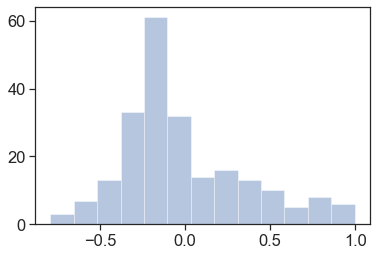

In [50]:
seaborn.distplot(ccs_within1[np.isfinite(ccs_within1)],kde=0)

In [54]:
np.percentile(ccs_within1[np.isfinite(ccs_within1)],95)

0.7642289670143062

# make it work

In [15]:
window0 = 6000
window1 = 6000
out1 = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC,get_time_mean=False,
                     window0=window0,window1=window1)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = out1
out2 = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC,get_time_mean=False,
                     window0=window0,window1=window1)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = out2

In [16]:
store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=1)
store_g1_p2 = get_mean_activity_matrix(all_resps_g1_single_trial,half=2)

store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=1)
store_g2_p2 = get_mean_activity_matrix(all_resps_g2_single_trial,half=2)

In [17]:
store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=1,order=poke_dict_t1['seq'])
store_g1_p2 = get_mean_activity_matrix(all_resps_g1_single_trial,half=2,order=poke_dict_t1['seq'])

store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=1,order=poke_dict_t2['seq'])
store_g2_p2 = get_mean_activity_matrix(all_resps_g2_single_trial,half=2,order=poke_dict_t2['seq'])

In [ ]:
def get_

In [ ]:
evals_shuff = []
for ctr in range(100):
    sys.stdout.write('\riter_num:{}'.format(ctr))
    sys.stdout.flush()
    store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=1,order=poke_dict_t1['seq'])
    store_g1_p2 = get_mean_activity_matrix(all_resps_g1_single_trial,half=2,order=np.random.permutation(poke_dict_t1['seq']))

    store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=1,order=np.random.permutation(poke_dict_t2['seq']))
    store_g2_p2 = get_mean_activity_matrix(all_resps_g2_single_trial,half=2,order=np.random.permutation(poke_dict_t2['seq']))
    

    conditions =  np.logical_and.reduce([ccs_across<.3,
                                        ccs_within>=.3])
    store_g1_filt = store_g1_p1[conditions]
    store_g1_cv_filt = store_g1_p2[conditions]
    store_g2_filt = store_g2_p1[conditions]
    store_g2_cv_filt = store_g2_p2[conditions]
    
    
    U,D,V = np.linalg.svd(store_g1_filt)
    #U2,D2,V2 = np.linalg.svd(store_g2_filt)
    evals = U.T.dot(store_g2_filt).dot(V.T).diagonal()
    evals_shuff.append(evals)


In [45]:
#def get_shuff_evals(n_shuff=100)

In [18]:
store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=1,order=poke_dict_t1['seq'])
store_g1_p2 = get_mean_activity_matrix(all_resps_g1_single_trial,half=2,order=poke_dict_t1['seq'])

store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=1,order=poke_dict_t2['seq'])
store_g2_p2 = get_mean_activity_matrix(all_resps_g2_single_trial,half=2,order=poke_dict_t2['seq'])

In [186]:
conditions =  np.logical_and.reduce([ccs_across<.3,
                                    ccs_within>=.3])
store_g1_filt = store_g1_p1[conditions]
store_g1_filt = store_g1_filt - np.mean(store_g1_filt,axis=1)[:,None]
#store_g1_filt = store_g1_filt/np.std(store_g1_filt,axis=1)[:,None]

store_g1_cv_filt = store_g1_p2[conditions]
store_g1_cv_filt = store_g1_cv_filt - np.mean(store_g1_cv_filt,axis=1)[:,None]

store_g2_filt = store_g2_p1[conditions]
store_g2_filt = store_g2_filt - np.mean(store_g2_filt,axis=1)[:,None]

store_g2_cv_filt = store_g2_p2[conditions]
store_g2_cv_filt = store_g2_cv_filt - np.mean(store_g2_cv_filt,axis=1)[:,None]


In [187]:
U,D,V = np.linalg.svd(store_g1_filt)
U2,D2,V2 = np.linalg.svd(store_g2_filt)
true_evals = U.T.dot(store_g1_filt).dot(V.T).diagonal()
#evals_shuff.append(evals)


In [217]:
ccs = []
for ix_ in range(store_g1_filt.shape[1]):
    ccs.append(np.cov(U[:,0],store_g1_filt[:,ix_])[0,1])

In [213]:
a = np.linalg.lstsq(U,store_g1_filt)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [248]:
mu_ccs_same = []
for n_compotents in range(1,U.shape[1]):
    #n_compotents = 1
    
    Un = U[:,:n_compotents]

    a,b,c,d = np.linalg.lstsq(Un,store_g1_filt[:,:])

    
    prediction = (U[:,:n_compotents].dot(a))
    ccs = []
    for i,(p,y) in enumerate(zip(prediction,store_g1_filt)):
        ccs.append(np.corrcoef(p,y)[0,1]**2 * np.var(y)/np.sum(np.var(store_g1_filt,axis=1)))
    mu_ccs_same.append(np.nansum(ccs))

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


In [350]:
mu_ccs_same = []
for n_compotents in range(1,U.shape[1]):
    #n_compotents = 1
    
    Un = U[:,:n_compotents]#.reshape(-1,1)

    a,b,c,d = np.linalg.lstsq(Un,store_g1_filt[:,:])

    
    prediction = (Un.dot(a))
    ccs = []
    for i,(p,y) in enumerate(zip(prediction,store_g1_filt)):
        ccs.append(np.corrcoef(p,y)[0,1]**2 * np.var(y)/np.sum(np.var(store_g1_filt,axis=1)))
    #mu_ccs_same.append(np.nansum(ccs))
    mu_ccs_same.append(np.corrcoef(prediction.flatten(),store_g1_filt.flatten())[0,1])

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


In [269]:
tmp_ = np.abs(U.T.dot(store_g1_filt)).sum(axis=1)
tmp_ /=np.sum(tmp_)
tmp_

array([0.42658884, 0.09569083, 0.09343441, 0.05236678, 0.04388151,
       0.0392748 , 0.03367573, 0.03092453, 0.02382848, 0.02163364,
       0.01976769, 0.01487717, 0.01373866, 0.0134108 , 0.01229536,
       0.01114842, 0.00993139, 0.00852598, 0.00798293, 0.00668323,
       0.00490878, 0.00390342, 0.00267388, 0.00267598, 0.00219859,
       0.00179976, 0.00139861, 0.0007798 ])

In [347]:
tmp = (U - np.mean(U,axis=1)[:,None]).T.dot(store_g1_filt)

In [349]:
np.abs(tmp).sum(axis=1)

array([0.60374508, 0.13599992, 0.13154174, 0.08018051, 0.06393617,
       0.06092662, 0.051835  , 0.04954659, 0.04240887, 0.03612543,
       0.0346291 , 0.03083506, 0.03011527, 0.02977838, 0.02931127,
       0.02893627, 0.02768449, 0.02598746, 0.02599496, 0.02552648,
       0.02490413, 0.02534216, 0.02421532, 0.0244096 , 0.02482014,
       0.02455079, 0.02428437, 0.02442621])

In [369]:
(U.T.dot(store_g1_filt))

array([[ 1.97223907e-04,  1.96390940e-04,  1.94690208e-04, ...,
        -1.29261479e-03, -1.29944070e-03, -1.30286343e-03],
       [ 7.38523908e-05,  7.05987547e-05,  6.41031909e-05, ...,
         2.00383534e-04,  2.03016103e-04,  2.04333445e-04],
       [-2.43130423e-04, -2.43509564e-04, -2.44279472e-04, ...,
         1.07590956e-04,  1.10626492e-04,  1.12166063e-04],
       ...,
       [-2.36837798e-07, -1.55497883e-07,  4.72086711e-09, ...,
        -1.60445445e-05, -1.64529024e-05, -1.66612966e-05],
       [ 4.20221961e-06,  4.17286614e-06,  4.11339229e-06, ...,
        -8.43409688e-07, -7.24512186e-07, -6.62559658e-07],
       [-1.08827022e-06, -1.09016337e-06, -1.09335301e-06, ...,
         5.56354802e-07,  5.74878192e-07,  5.84914595e-07]])

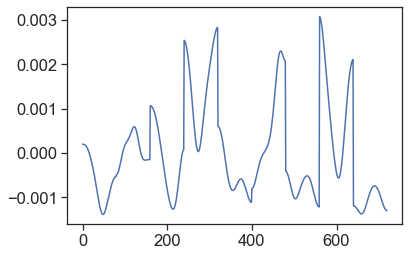

In [372]:
plt.plot((U.T.dot(store_g1_filt))[0])

In [352]:
np.cov(U[:,0],store_g1_filt[:,0])[0,1]

6.028259694076081e-06

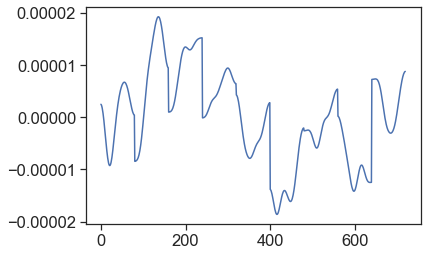

In [205]:
plt.plot(ccs)

In [206]:
ccs[0]/U.dot(store_g1_filt)[0][0]

2.232125236744107

In [207]:
np.var(store_g1_filt[0])

3.1522553729353235e-09

In [208]:
store_g1_filt[0].shape

(720,)

In [359]:
ccs = []
for ix_ in range(store_g1_filt.shape[1]):
    ccs.append(np.cov(U[:,0],store_g1_filt[:,ix_])[0,1])

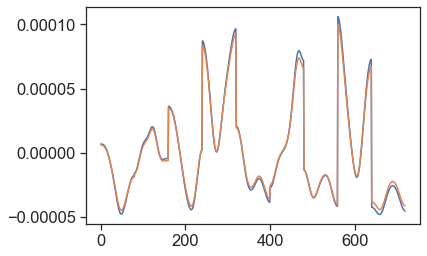

In [366]:
plt.plot((U-np.mean(U,axis=1)[:,None]).T.dot(store_g1_filt)[0]/28)
plt.plot(ccs)

In [355]:
(U-np.mean(U,axis=1)[:,None]).shape

(28, 28)

In [356]:
U.shape

(28, 28)

In [23]:
import scipy.stats as stt

In [24]:
mu = np.mean(np.cumsum(np.abs(evals_shuff),axis=1),axis=1)
for i in np.abs(evals_shuff):
    plt.plot(np.cumsum(i),color='.3',linewidth=.5)
sem =np.std(np.cumsum(np.abs(evals_shuff),axis=1),axis=0)
plt.plot(np.cumsum(np.abs(true_evals)),linewidth=3)
plt.plot(mu,linewidth=3,color='.3',label='shuffle')
plt.fill_between(range(len(mu)),mu+2*sem,mu-2*sem,color='.3',alpha=.3)
plt.legend()
seaborn.despine()

NameError: name 'evals_shuff' is not defined

In [25]:
U.T.dot(-store_g1_filt).dot(V.T).diagonal()


array([-7.43492446e-02, -9.24290712e-03, -6.12463198e-03, -4.61153675e-03,
       -3.72405210e-03, -2.71861193e-03, -2.31865975e-03, -2.12309259e-03,
       -1.84721378e-03, -1.55945577e-03, -1.31613173e-03, -1.15702995e-03,
       -9.93122980e-04, -9.30028015e-04, -8.41716364e-04, -7.65430603e-04,
       -7.10527864e-04, -5.79957197e-04, -5.44852858e-04, -4.56304056e-04,
       -3.60971301e-04, -2.71422867e-04, -2.43074492e-04, -1.85034076e-04,
       -1.55390554e-04, -1.30392506e-04, -1.13406506e-04, -6.78725933e-05])

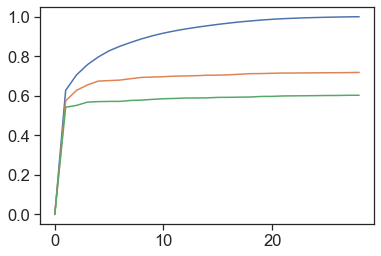

In [26]:
#this is the correct equation to testimate. This returns the corresponding D
evals = np.abs(U.T.dot(store_g1_filt).dot(V.T).diagonal())
mx = np.sum(evals)
plt.plot([0]+(np.cumsum(evals)/mx).tolist())

evals = np.abs(U.T.dot(store_g1_cv_filt).dot(V.T).diagonal())
plt.plot([0]+(np.cumsum(evals)/mx).tolist())


evals = np.abs(U.T.dot(store_g2_filt).dot(V.T).diagonal())
plt.plot([0]+(np.cumsum(evals)/mx).tolist())
#plt.ylim(.2,1)


In [27]:
U.T.dot(store_g1_filt).dot(V.T).shape

(28, 720)

(0.2, 1)

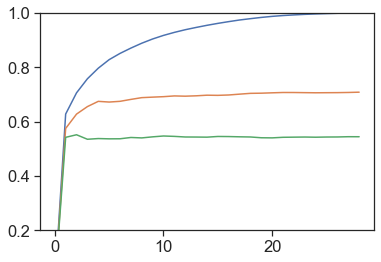

In [28]:
#this is the correct equation to testimate. This returns the corresponding D
evals = U.T.dot(store_g1_filt).dot(V.T).diagonal()
mx = np.sum(evals)
plt.plot([0]+(np.cumsum(evals)/mx).tolist())

evals = U.T.dot(store_g1_cv_filt).dot(V.T).diagonal()
plt.plot([0]+(np.cumsum(evals)/mx).tolist())


evals = U.T.dot(store_g2_filt).dot(V.T).diagonal()
plt.plot([0]+(np.cumsum(evals)/mx).tolist())
plt.ylim(.2,1)


In [90]:
ccs = np.array(ccs)

In [91]:
np.nanmean(ccs)

-0.4469240982455855